<a href="https://colab.research.google.com/github/bee20/Time-Series-Forecasting/blob/main/KAGGLE_SALES_FORECAST_COMPET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
## create a SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

import matplotlib.pyplot as plt

In [68]:
holiday = pd.read_csv("holidays_events.csv")
holiday['holiday'] = 1
holiday['date'] = pd.to_datetime(holiday['date'])

holiday

,date,type,locale,locale_name,description,transferred,holiday
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,1
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,1
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,1
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,1
...,...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False,1
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False,1
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False,1
348,2017-12-25,Holiday,National,Ecuador,Navidad,False,1


In [151]:
df_full = pd.read_csv("train.csv")
df_full['date'] = pd.to_datetime(df_full['date'])
df_full = df_full[df_full['family'] == 'GROCERY I']
df_full = df_full.groupby(['date'])['sales'].sum().reset_index()

df= df_full.copy()
df = df[df['date']>= pd.to_datetime('2013-01-06')]
print(len(df))
print(df['date'].min(), df['date'].max())

per1 = pd.date_range(start = df['date'].min(),
         end = df['date'].max(), freq ='D')
skeleton = pd.DataFrame({'date': per1.to_list()})
avg = df['sales'].mean()
df = pd.merge( skeleton, df, on='date', how = 'left').fillna( avg )
print(len(df))

# bring in exogenous variable
df = pd.merge(df, holiday[['date','holiday']].drop_duplicates(), on ='date', how = 'left')
df['holiday'] = df['holiday'].fillna(0)
print(len(df))
print(df['holiday'].unique())

df.set_index("date", inplace = True)

df_train = df.head(1400)
df_test = df.tail(283)

df.sort_values(['date'])
print(len(df), len(df_train), len(df_test)   )

1679
2013-01-06 00:00:00 2017-08-15 00:00:00
1683
1683
[0. 1.]
1683 1400 283


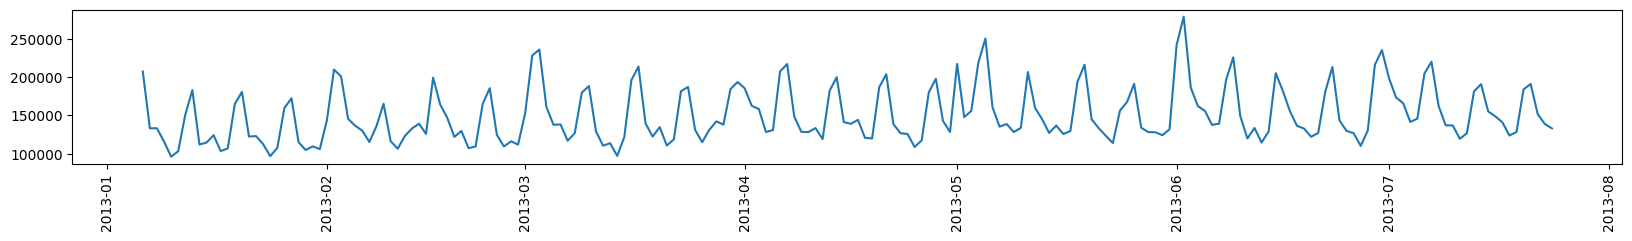

In [152]:
# df.columns
plt.figure(figsize=(20, 2))
plt.xticks(rotation=90)
plt.plot(df[['sales']].head(200))

# looks like seasonality is there and trend is there -> check stationarity

In [153]:
df['df_diff'] = df['sales'] - df['sales'].shift(7)
print(len(df))
df = df.dropna()
print(len(df))
fuller = adfuller( df['sales'] )
print("ADF stat is ", fuller[0])
print("p value is ", fuller[1])

1683
1676
ADF stat is  -3.685964564390826
p value is  0.004314962793696793


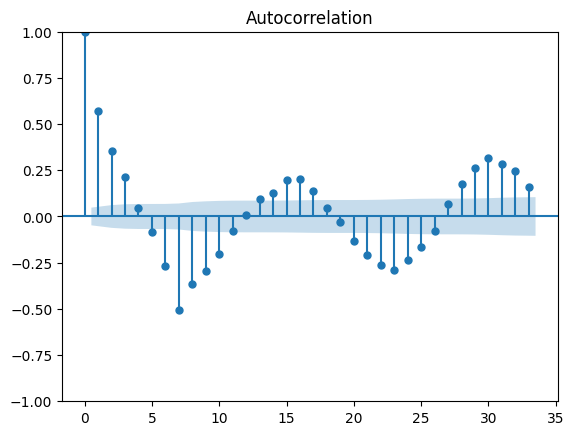

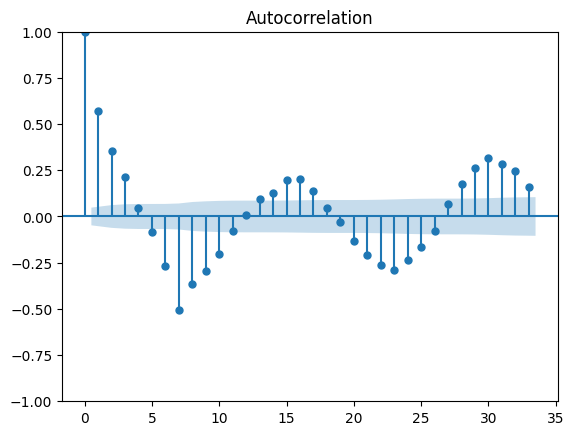

In [154]:
 plot_acf(df['df_diff'])


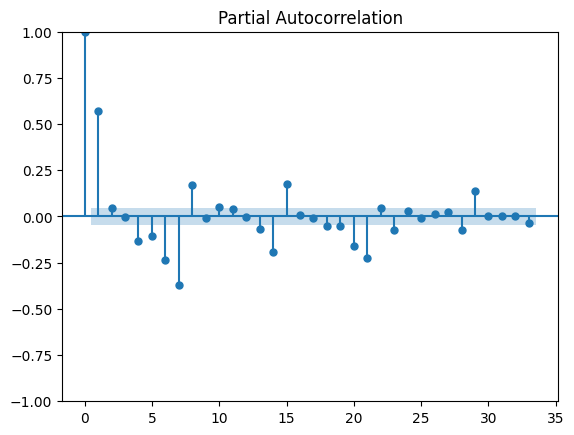

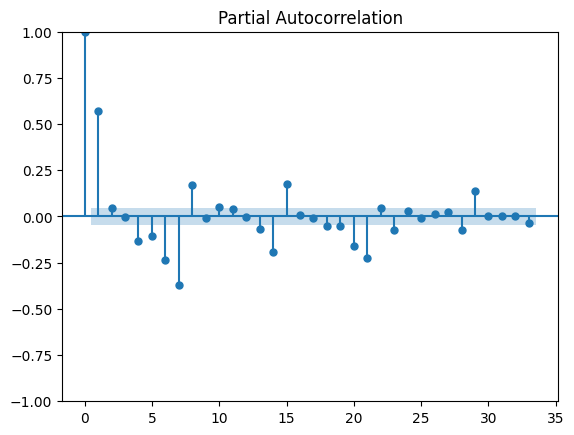

In [155]:
plot_pacf(df['df_diff'])

In [156]:
# ARIMA(P,D,Q) = ARIMA(3,0,1)

# !pip install pmdarima
import pmdarima as pm
model = pm.auto_arima(df_train['sales'], exogenous= df_train['holiday'])
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1400
Model:               SARIMAX(3, 1, 4)   Log Likelihood              -16597.263
Date:                Thu, 27 Jun 2024   AIC                          33212.525
Time:                        23:01:07   BIC                          33259.717
Sample:                    01-06-2013   HQIC                         33230.167
                         - 11-05-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    258.0822    310.995      0.830      0.407    -351.456     867.621
ar.L1          0.9980      0.076     13.055      0.000       0.848       1.148
ar.L2         -0.6886      0.096     -7.206      0.000      -0.876      -0.501
ar.L3         -0.2456      0.076     -3.237      0.001      -0.394      -0.097
ma.L1         -1.4135      0.072    -19.659      0.000      -1.554      -1.273
ma.L2          0.7133      0.129      5.524      0.000       0.460       0.966
ma.L3          0.4196      0.120      3.490      0.000       0.184       0.655
ma.L4         -0.5018      0.047    -10.716      0.000      -0.594      -0.410
sigma2      1.586e+09   3.49e-05   4.54e+13      0.000    1.59e+09    1.59e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              2725.14
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               2.34   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.04e+29. Standard errors may be unstable.
"""

In [175]:
sarimamodel = SARIMAX(df_train['sales'], order=((3,1,4)		 ))
model_sArima_fit = sarimamodel.fit()

sarimamodel_ex = SARIMAX(df_train['sales'], exog= df_train['holiday'],  order=((5, 1, 5)		 ))
model_sArima_fit_ex = sarimamodel_ex.fit()


display(model_sArima_fit.summary(), model_sArima_fit_ex.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1400
Model:               SARIMAX(3, 1, 4)   Log Likelihood              -16609.097
Date:                Thu, 27 Jun 2024   AIC                          33234.194
Time:                        23:08:24   BIC                          33276.142
Sample:                    01-06-2013   HQIC                         33249.876
                         - 11-05-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6096      0.057     10.624      0.000       0.497       0.722
ar.L2         -0.2063      0.071     -2.893      0.004      -0.346      -0.067
ar.L3         -0.6336      0.057    -11.171      0.000      -0.745      -0.522
ma.L1         -1.1132      0.052    -21.610      0.000      -1.214      -1.012
ma.L2          0.2141      0.077      2.772      0.006       0.063       0.365
ma.L3          0.8642      0.067     12.883      0.000       0.733       0.996
ma.L4         -0.6188      0.028    -22.309      0.000      -0.673      -0.564
sigma2      1.586e+09   6.36e-11   2.49e+19      0.000    1.59e+09    1.59e+09
===================================================================================
Ljung-Box (L1) (Q):                   5.26   Jarque-Bera (JB):              2471.17
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               2.41   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.21e+35. Standard errors may be unstable.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1400
Model:               SARIMAX(5, 1, 5)   Log Likelihood              -16429.743
Date:                Thu, 27 Jun 2024   AIC                          32883.485
Time:                        23:08:24   BIC                          32946.408
Sample:                    01-06-2013   HQIC                         32907.008
                         - 11-05-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday     2385.3400   2239.125      1.065      0.287   -2003.265    6773.945
ar.L1         -0.0802      2.543     -0.032      0.975      -5.065       4.904
ar.L2         -0.7375      2.036     -0.362      0.717      -4.729       3.254
ar.L3         -0.4707      3.671     -0.128      0.898      -7.665       6.724
ar.L4         -0.2919      2.037     -0.143      0.886      -4.284       3.700
ar.L5         -0.8794      2.538     -0.347      0.729      -5.853       4.094
ma.L1          0.0804      2.541      0.032      0.975      -4.899       5.060
ma.L2          0.7102      2.029      0.350      0.726      -3.267       4.688
ma.L3          0.4548      3.597      0.126      0.899      -6.596       7.505
ma.L4          0.2670      2.015      0.132      0.895      -3.682       4.216
ma.L5          0.8552      2.458      0.348      0.728      -3.962       5.672
sigma2      1.089e+09      0.016      7e+10      0.000    1.09e+09    1.09e+09
===================================================================================
Ljung-Box (L1) (Q):                  82.39   Jarque-Bera (JB):             15486.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.35   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.09e+26. Standard errors may be unstable.
"""

In [163]:
arimamodel = ARIMA(df_train['sales'], order=(5, 1, 5))
model_Arima_fit = arimamodel.fit()
model_Arima_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1400
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -16433.603
Date:                Thu, 27 Jun 2024   AIC                          32889.206
Time:                        23:01:56   BIC                          32946.885
Sample:                    01-06-2013   HQIC                         32910.769
                         - 11-05-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0698      0.248     -0.282      0.778      -0.556       0.416
ar.L2         -0.7461      0.198     -3.771      0.000      -1.134      -0.358
ar.L3         -0.4556      0.358     -1.274      0.203      -1.157       0.245
ar.L4         -0.3006      0.198     -1.520      0.128      -0.688       0.087
ar.L5         -0.8688      0.247     -3.518      0.000      -1.353      -0.385
ma.L1          0.0876      0.246      0.356      0.722      -0.395       0.570
ma.L2          0.7101      0.187      3.794      0.000       0.343       1.077
ma.L3          0.4497      0.342      1.313      0.189      -0.222       1.121
ma.L4          0.2695      0.188      1.432      0.152      -0.099       0.638
ma.L5          0.8546      0.233      3.666      0.000       0.398       1.311
sigma2      1.093e+09   1.17e-08   9.34e+16      0.000    1.09e+09    1.09e+09
===================================================================================
Ljung-Box (L1) (Q):                  94.23   Jarque-Bera (JB):             15118.83
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.34   Skew:                             0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.21e+31. Standard errors may be unstable.
"""

<Axes: ylabel='Density'>

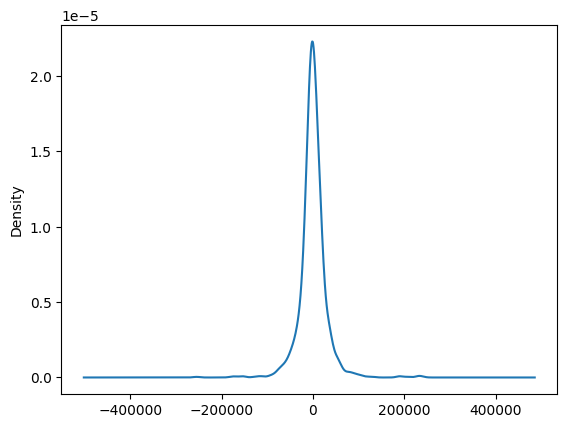

In [176]:
model_sArima_fit_ex.resid.plot(kind='kde')

In [165]:
pred_start_date=df_test.index[0]
pred_end_date=df_test.index[-1]
print(pred_start_date)
print(pred_end_date)

2016-11-06 00:00:00
2017-08-15 00:00:00


In [177]:
##prediction
pred = model_Arima_fit.predict(start=datetime(2016,11,6), end  =datetime(2017,8,15)  )

preds = model_sArima_fit.predict(start=datetime(2016,11,6), end  =datetime(2017,8,15)  )
preds_ex = model_sArima_fit_ex.predict(pred_start_date , pred_end_date, exog = df_test['holiday'])

In [178]:

df_test['Predicted_ARIMA']=pred
df_test['Predicted_SARIMA']=preds
df_test['Predicted_SARIMA_EXOG']=preds_ex

display( df_test)


,sales,holiday,Predicted_ARIMA,Predicted_SARIMA,Predicted_SARIMA_EXOG
date,,,,,
2016-11-06,351095.489,1.0,287006.119243,296920.441120,289113.419590
2016-11-07,250798.331,1.0,226221.516317,278116.974813,227966.744097
2016-11-08,226945.098,0.0,199243.237506,233446.237581,200388.016035
2016-11-09,224668.166,0.0,205757.170558,208155.714939,206942.673412
2016-11-10,176812.224,1.0,187622.597877,213866.164312,190257.429188
...,...,...,...,...,...
2017-08-11,238221.922,1.0,205877.025265,253013.408639,207260.526436
2017-08-12,238627.633,0.0,267583.644707,278525.770727,266973.052463
2017-08-13,258442.452,0.0,276802.156881,284817.957149,276665.934345


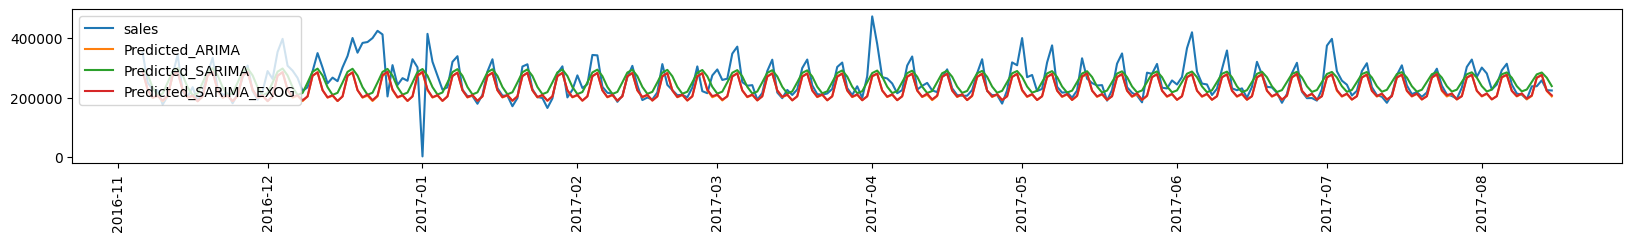

In [179]:

# df.columns
plt.figure(figsize=(20, 2))
plt.xticks(rotation=90)
plt.plot(df_test[['sales', 'Predicted_ARIMA', 'Predicted_SARIMA', 'Predicted_SARIMA_EXOG']])
plt.legend(['sales', 'Predicted_ARIMA', 'Predicted_SARIMA' , 'Predicted_SARIMA_EXOG'], loc='upper left')

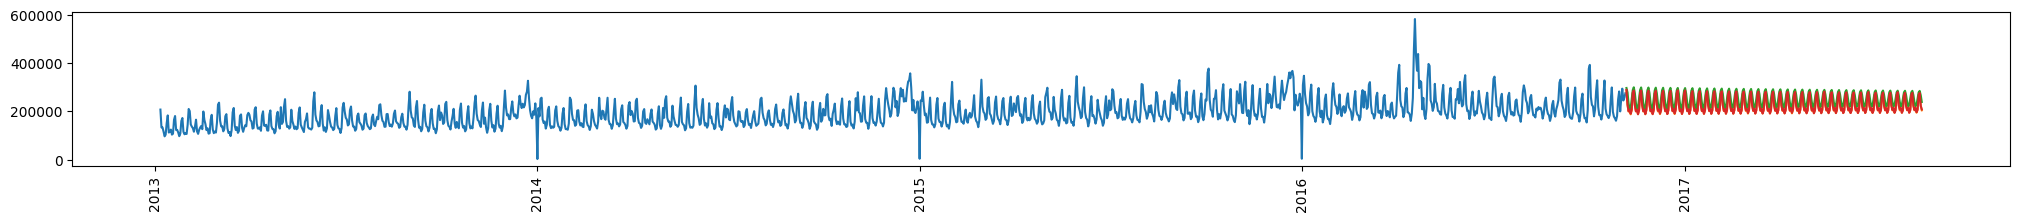

In [180]:
# df.columns
plt.figure(figsize=(25, 2))
plt.xticks(rotation=90)
plt.plot(df_train[['sales']])
plt.plot(df_test[['Predicted_ARIMA', 'Predicted_SARIMA', 'Predicted_SARIMA_EXOG']])


In [183]:
print('RMSE for ARIMA is : ', ((df_test.sales - df_test.Predicted_ARIMA) ** 2).mean() ** .5)
print('RMSE for SARIMA is :', ((df_test.sales - df_test.Predicted_SARIMA) ** 2).mean() ** .5)
print('RMSE for SARIMA with exog is : ', ((df_test.sales - df_test.Predicted_SARIMA_EXOG) ** 2).mean() ** .5)

RMSE for ARIMA is :  55348.6452168691
RMSE for SARIMA is : 49481.304118804794
RMSE for SARIMA with exog is :  54957.48860297895


EXPONENTIAL SMOOTHING

In [184]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
<ipython-input-185-bc91cf290fc7>:13: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  fitH = modelH.fit(smoothing_level=1, smoothing_s

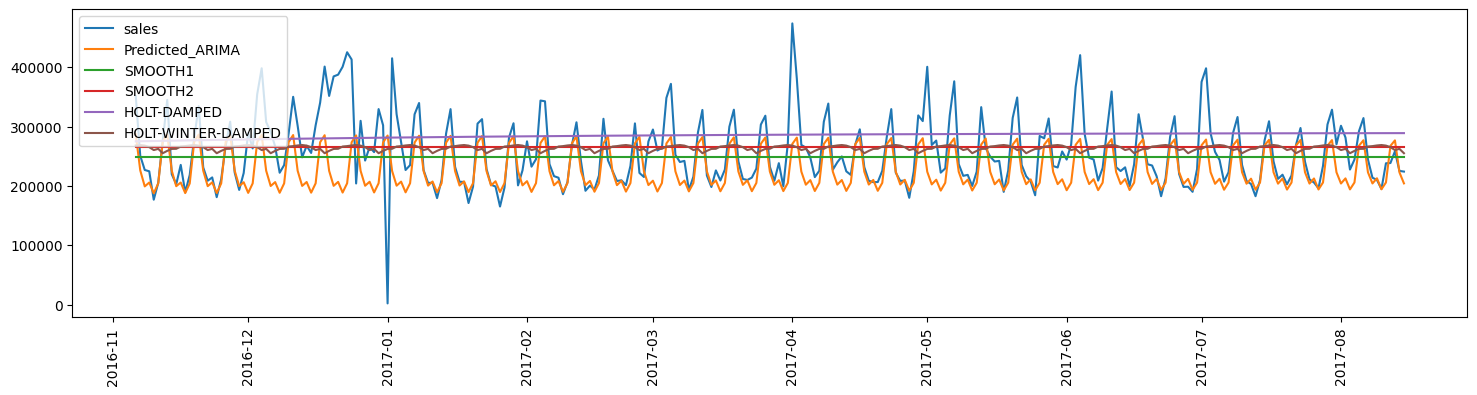

In [185]:
model_SIMPL = SimpleExpSmoothing(df_train['sales'])
fit1 = model_SIMPL.fit(smoothing_level=.2)
pred1 = fit1.forecast(len(df_test))

fit2 = model_SIMPL.fit(smoothing_level=.5)
pred2 = fit2.forecast(len(df_test))

df_test['SMOOTH1'] = pred1
df_test['SMOOTH2'] = pred2


modelH = Holt(df_train['sales'])
fitH = modelH.fit(smoothing_level=1, smoothing_slope=1)
predH = fitH.forecast(len(df_test))
df_test['SMOOTHH'] = predH

modelHH = ExponentialSmoothing(np.asarray(df_train['sales']), trend='mul', seasonal=None, damped=True)
fitHH = modelHH.fit()
predHH = fitHH.forecast(len(df_test))
df_test['SMOOTHHH'] = predHH

model2H = ExponentialSmoothing(df_train['sales'], trend="mul", seasonal="mul", seasonal_periods=12, damped=True)
fitHH2 = model2H.fit(smoothing_level=.5, smoothing_slope=0)
predHHH = fitHH2.forecast(len(df_test))
df_test['SMOOTHHW'] = predHHH

# df.columns
plt.figure(figsize=(18, 4))
plt.xticks(rotation=90)
plt.plot(df_test[['sales', 'Predicted_ARIMA', 'SMOOTH1', 'SMOOTH2',  'SMOOTHHH', 'SMOOTHHW' ]])
plt.legend(['sales', 'Predicted_ARIMA', 'SMOOTH1', 'SMOOTH2',  'HOLT-DAMPED', 'HOLT-WINTER-DAMPED'], loc='upper left')